In [1]:
#调用包
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data=pd.read_excel("USA.xlsx")
print(data[data.isnull().T.any()])
print("---------------------------------")
data

Empty DataFrame
Columns: [日期, 累计确诊, 治愈人数, 死亡人数]
Index: []
---------------------------------


,日期,累计确诊,治愈人数,死亡人数
0,2020-02-29,17,7,1
1,2020-03-01,24,7,1
2,2020-03-02,42,7,6
3,2020-03-03,60,7,7
4,2020-03-04,89,7,11
...,...,...,...,...
424,2021-04-28,6134597,25521913,574340
425,2021-04-29,6129108,25584747,575194
426,2021-04-30,6129165,25641574,576232
427,2021-05-01,6105410,25710142,576722


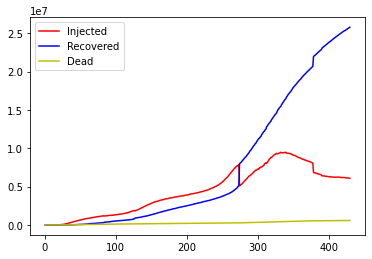

In [3]:
x=list(range(1,data.shape[0]+1))
y1=data['累计确诊'].tolist()
y2=data['治愈人数'].tolist()
y3=data['死亡人数'].tolist()
plt.plot(x,y1,'r',label='Injected')
plt.plot(x,y2,'b',label='Recovered')
plt.plot(x,y3,'y',label='Dead')
plt.legend()
plt.show()

In [4]:
def delta_s(beta,s,i,n,alpha):
    return (-beta*s*i/n-alpha*s)
def delta_e(beta,s,i,n,r1,e):
    return (beta*s*i/n-r1*e)
def delta_i(r1,e,r2d,r2r,i):
    return r1*e-r2d*i-r2r*i
def delta_r(r2r,i,alpha,s):
    return r2r*i+alpha*s
def delta_d(r2d,i):
    return r2d*i
def count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha):
    s=s;e=e;i=i;r=r;d=d;beta=beta;r1=r1;r2d=r2d;r2r=r2r;n=n;alpha=alpha
    S=[s];E=[e];I=[i];R=[r];D=[d]
    for m in range(30):
        ds=delta_s(beta,s,i,n,alpha)
        de=delta_e(beta,s,i,n,r1,e)
        di=delta_i(r1,e,r2d,r2r,i)
        dr=delta_r(r2r,i,alpha,s)
        dd=delta_d(r2d,i)
        s=s+ds
        e=e+de
        i=i+di
        r=r+dr
        d=d+dd
        S.append(s)
        E.append(e)
        I.append(i)
        R.append(r)
        D.append(d)
    result=pd.DataFrame({
        'S':S,
        'E':E,
        '累计确诊':I,
        '治愈人数':R,
        '死亡人数':D
        })
    return result
def loss(beta,r1,e0,r2d,r2r,alpha):
    n=326766748#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[0]#初始的感染数量
    r=y2[0]#初始的治愈数量
    d=y3[0]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    alpha=alpha
    r2d=r2d
    r2r=r2r
    predict=count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    Inject_predict=np.array(predict['累计确诊'].tolist())
    Recovered_predict=np.array(predict['治愈人数'].tolist())
    Dead_predict=np.array(predict['死亡人数'].tolist())
    Inject_true=np.array(data.iloc[:31,1].tolist())
    Recovered_true=np.array(data.iloc[:31,2].tolist())
    Dead_true=np.array(data.iloc[:31,3].tolist())
    loss1=np.sum((Inject_predict-Inject_true)**2)
    loss2=np.sum((Recovered_predict-Recovered_true)**2)
    loss3=np.sum((Dead_predict-Dead_true)**2)
    loss=loss1+loss2+loss3
    return 10000000/loss

In [5]:
import random
import math
import matplotlib.pyplot as plt
#初始化生成chromosome_length大小的population_size个个体的二进制基因型种群
def species_origin(population_size,chromosome_length):
    population=[[]]
    #二维列表，包含染色体和基因
    for i in range(population_size):
        temporary=[]
        #染色体暂存器
        for j in range(chromosome_length):
            temporary.append(random.randint(0,1))
            #随机产生一个染色体,由二进制数组成
        population.append(temporary)
            #将染色体添加到种群中
    return population[1:]
def translation(population):
    temporary=[]
    for i in range(len(population)):
        temp_beta=0
        temp_r1=0
        temp_e0=0
        temp_r2d=0
        temp_r2r=0
        temp_alpha=0
        for j in range(0,15):
            temp_beta+=population[i][j]*(math.pow(2,j))/32768.0
        for j in range(15,30):
            temp_r1+=population[i][j]*(math.pow(2,j-15))/32768.0
        for j in range(30,50):
            temp_e0+=population[i][j]*(math.pow(2,j-30))
        for j in range(50,65):
            temp_r2d+=population[i][j]*(math.pow(2,j-50))/32768.0
        for j in range(65,80):
            temp_r2r+=population[i][j]*(math.pow(2,j-65))/32768.0
        for j in range(80,95):
            temp_alpha+=population[i][j]*(math.pow(2,j-80))/32768.0
        total=[temp_beta,temp_r1,temp_e0,temp_r2d,temp_r2r,temp_alpha]
        temporary.append(total)
        #一个染色体编码完成，由一个二进制数编码为一个十进制数
    return temporary
def function(temporary):
    ##本函数返回每个个体的损失值
    function1=[]
    for i in range(len(temporary)):
        x=loss(temporary[i][0],temporary[i][1],temporary[i][2],temporary[i][3],temporary[i][4],temporary[i][5])
        #一个基因代表一个决策变量，其算法是先转化成十进制，然后再除以2的基因个数次方减1(固定值)。
        function1.append(x)
    return function1
def sum(fitness1):
    total=0
    for i in range(len(fitness1)):
        total+=fitness1[i]
    return total
def newborn(population,born_size,chromosome_length):
    population=population
    #二维列表，包含染色体和基因
    for i in range(born_size):
        temporary=[]
        #染色体暂存器
        for j in range(chromosome_length):
            temporary.append(random.randint(0,1))
            #随机产生一个染色体,由二进制数组成
        population.append(temporary)
            #将染色体添加到种群中
    return population[1:]

In [6]:
def random_pick(some_list,probabilities,size):
    item_list=[]
    i=0
    while i<size:
        for item,item_probability in zip(some_list,probabilities):
            x=random.uniform(0,1)
            cumulative_probability=item_probability
            if x < cumulative_probability:
                item_list.append(item)
                i=i+1
    return item_list

def selection(population,next_size,fitness1):
    new_fitness=[]
    #单个适应度暂存器
    total_fitness=sum(fitness1)
    #将所有的适应度求和
    for i in range(len(fitness1)):
        new_fitness.append(fitness1[i]/total_fitness)
    select=random_pick(list(range(len(new_fitness))),new_fitness,next_size)
    result=[]
    for i in select:
        result.append(population[i])
    return result

In [7]:
def crossover(population):
#pc是概率阈值，选择单点交叉还是多点交叉，生成新的交叉个体，这里没用
    pop_len=len(population)

    for i in range(pop_len-1):
        cpoint=random.randint(0,len(population[0]))
        #在种群个数内随机生成单点交叉点
        temporary1=[]
        temporary2=[]

        temporary1.extend(population[i][0:cpoint])
        temporary1.extend(population[i+1][cpoint:len(population[i])])
        #将tmporary1作为暂存器，暂时存放第i个染色体中的前0到cpoint个基因，
        #然后再把第i+1个染色体中的后cpoint到第i个染色体中的基因个数，补充到temporary2后面

        temporary2.extend(population[i+1][0:cpoint])
        temporary2.extend(population[i][cpoint:len(population[i])])
        # 将tmporary2作为暂存器，暂时存放第i+1个染色体中的前0到cpoint个基因，
        # 然后再把第i个染色体中的后cpoint到第i个染色体中的基因个数，补充到temporary2后面
        population[i]=temporary1
        population[i+1]=temporary2
    return population
def mutation(population,pm):
    # pm是概率阈值
    px=len(population)
    # 求出种群中所有个体的个数
    py=len(population[0])
    # 染色体/个体中基因的个数
    for i in range(px):
        if(random.random()<pm):
        #如果小于阈值就变异
            mpoint=random.randint(0,py-1)
            # 生成0到py-1的随机数
            if(population[i][mpoint]==1):
            #将mpoint个基因进行单点随机变异，变为0或者1
                population[i][mpoint]=0
            else:
                population[i][mpoint]=1
    return population

In [8]:
def best(population,fitness1):

    px=len(population)
    bestindividual=[]
    bestfitness=fitness1[0]

    for i in range(1,px):
   # 循环找出最大的适应度，适应度最大的也就是最好的个体
        if(fitness1[i]>bestfitness):

            bestfitness=fitness1[i]
            bestindividual=population[i]

    return [bestindividual,bestfitness]
def next_best(population,fitness1,temp_individual,temp_fitness):

    px=len(population)
    bestindividual=temp_individual
    bestfitness=temp_fitness

    for i in range(0,px):
   # 循环找出最大的适应度，适应度最大的也就是最好的个体
        if(fitness1[i]>bestfitness):

            bestfitness=fitness1[i]
            bestindividual=population[i]

    return [bestindividual,bestfitness]

In [9]:
population_size=500
chromosome_length=95
population=species_origin(population_size,chromosome_length)
results=[]
pm=0.5
for m in range(300):
    temporary=translation(population)
    fitness1=function(temporary)
    if m==0:
        best_individual,best_fitness=best(population,fitness1)
    else:
        best_individual,best_fitness=next_best(population,fitness1,best_individual,best_fitness)
    print(10000000/best_fitness)
    results.append([best_fitness,best_individual])
     #将最好的个体和最好的适应度保存，并将最好的个体转成十进制
    population=selection(population,450,fitness1)#选择
    population=crossover(population)#交配
    population=mutation(population,pm)#变异
    population=newborn(population,50,95)

8073894907757091.0
77113673431484.28
31366921865739.47
22479101265302.664
9522077490962.81
1111577754851.5515
1063324801053.5696
87850308314.74208
87544828991.316
87494229565.28468
87393630877.35823
87393630877.35823
87393630877.35823
87393630877.35823
87230496155.39626
87230496155.39626
87230496155.39626
87230496155.39626
87230496155.39626
87230496155.39626
87230496155.39626
87109604062.59862
87109604062.59862
87109604062.59862
87109604062.59862
87109604062.59862
86944651851.44995
86944651851.44995
86944651851.44995
86944651851.44995
86868008747.13829
86630444902.94824
86630444902.94824
86291709198.5772
86291709198.5772
86291709198.5772
86291709198.5772
86291709198.5772
86291709198.5772
86291709198.5772
86291709198.5772
86291709198.5772
86291709198.5772
86291709198.5772
86291709198.5772
86291709198.5772
86291709198.5772
86291709198.5772
86291709198.5772
86236284744.74577
86236284744.74577
86236284744.74577
86236284744.74577
86236284744.74577
86185972101.31313
85433391570.62312
8543339

In [10]:
best=[]
best.append(best_individual)
print(best_individual)
print(translation(best))
print(10000000/best_fitness)

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[0.969696044921875, 0.0506591796875, 8460.0, 0.01556396484375, 0.009521484375, 0.0]]
1622820569.6933074


In [11]:
first=translation(best)

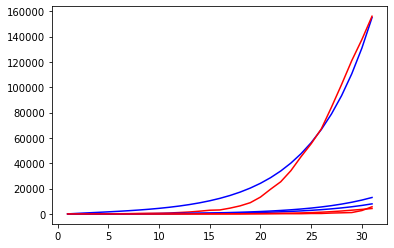

In [12]:
def yuce(beta,r1,e0,r2d,r2r,alpha):
    n=326766748#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[0]#初始的感染数量
    r=y2[0]#初始的治愈数量
    d=y3[0]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    r2d=r2d
    r2r=r2r
    predict=count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    return predict
predict=yuce(first[0][0],first[0][1],first[0][2],first[0][3],first[0][4],first[0][5])
Inject_predict=np.array(predict['累计确诊'].tolist())
Recovered_predict=np.array(predict['治愈人数'].tolist())
Dead_predict=np.array(predict['死亡人数'].tolist())
Inject_true=np.array(data.iloc[:31,1].tolist())
Recovered_true=np.array(data.iloc[:31,2].tolist())
Dead_true=np.array(data.iloc[:31,3].tolist())
x=list(range(1,len(Inject_predict)+1))
plt.plot(x,Inject_predict,'b')
plt.plot(x,Inject_true,'r')
plt.plot(x,Recovered_predict,'b')
plt.plot(x,Recovered_true,'r')
plt.plot(x,Dead_predict,'b')
plt.plot(x,Dead_true,'r')
plt.show()

In [13]:
predict

,S,E,累计确诊,治愈人数,死亡人数
0,3.267583e+08,8460.000000,17.000000,7.000000,1.000000
1,3.267582e+08,8047.907745,445.150208,7.161865,1.264587
2,3.267578e+08,8071.856505,841.683819,11.400356,8.192890
3,3.267570e+08,8479.098034,1229.483432,19.414435,21.292827
4,3.267558e+08,9241.743533,1628.185438,31.120943,40.428464
5,3.267542e+08,10352.356501,2055.520821,46.623685,65.769485
6,3.267522e+08,11821.068651,2528.399046,66.195294,97.761539
7,3.267498e+08,13673.892669,3063.818661,90.269406,137.113452
8,3.267468e+08,15952.003075,3679.669580,119.441508,184.798618
9,3.267432e+08,18711.831030,4395.478805,154.477424,242.068866


In [14]:
def month_species_origin(population_size,chromosome_length):
    population=[[]]
    #二维列表，包含染色体和基因
    for i in range(population_size):
        temporary=[]
        #染色体暂存器
        for j in range(chromosome_length):
            temporary.append(random.randint(0,1))
            #随机产生一个染色体,由二进制数组成
        population.append(temporary)
            #将染色体添加到种群中
    return population[1:]

def month_translation(population):
    temporary=[]
    for i in range(len(population)):
        temp_beta=0
        temp_r1=0
        temp_r2d=0
        temp_r2r=0
        temp_alpha=0
        for j in range(0,15):
            temp_beta+=population[i][j]*(math.pow(2,j))/32768.0
        for j in range(15,30):
            temp_r1+=population[i][j]*(math.pow(2,j-15))/32768.0
        for j in range(30,45):
            temp_r2d+=population[i][j]*(math.pow(2,j-30))/32768.0
        for j in range(45,60):
            temp_r2r+=population[i][j]*(math.pow(2,j-45))/32768.0
        for j in range(60,75):
            temp_alpha+=population[i][j]*(math.pow(2,j-60))/32768.0
        total=[temp_beta,temp_r1,temp_r2d,temp_r2r,temp_alpha]
        temporary.append(total)
        #一个染色体编码完成，由一个二进制数编码为一个十进制数
    return temporary
def month_loss(beta,r1,e0,r2d,r2r,month,alpha):
    n=326766748#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[30*month]#初始的感染数量
    r=y2[30*month]#初始的治愈数量
    d=y3[30*month]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    r2d=r2d
    r2r=r2r
    alpha=alpha
    predict=count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    Inject_predict=np.array(predict['累计确诊'].tolist())
    Recovered_predict=np.array(predict['治愈人数'].tolist())
    Dead_predict=np.array(predict['死亡人数'].tolist())
    Inject_true=np.array(data.iloc[30*month:30*(month+1)+1,1].tolist())
    Recovered_true=np.array(data.iloc[30*month:30*(month+1)+1,2].tolist())
    Dead_true=np.array(data.iloc[30*month:30*(month+1)+1,3].tolist())
    loss1=np.sum((Inject_predict-Inject_true)**2)
    loss2=np.sum((Recovered_predict-Recovered_true)**2)
    loss3=np.sum((Dead_predict-Dead_true)**2)
    loss=loss1+loss2+loss3
    return 10000000/loss
def month_function(temporary,e0,month):
    ##本函数返回每个个体的损失值
    function1=[]
    for i in range(len(temporary)):
        x=month_loss(temporary[i][0],temporary[i][1],e0,temporary[i][2],temporary[i][3],month,temporary[i][4])
        #一个基因代表一个决策变量，其算法是先转化成十进制，然后再除以2的基因个数次方减1(固定值)。
        function1.append(x)
    return function1
def month_best(population,fitness1):

    px=len(population)
    bestindividual=[]
    bestfitness=fitness1[0]

    for i in range(1,px):
   # 循环找出最大的适应度，适应度最大的也就是最好的个体
        if(fitness1[i]>bestfitness):

            bestfitness=fitness1[i]
            bestindividual=population[i]

    return [bestindividual,bestfitness]
def month_yuce(beta,r1,e0,r2d,r2r,month,alpha):
    n=326766748#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[30*month]#初始的感染数量
    r=y2[30*month]#初始的治愈数量
    d=y3[30*month]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    r2d=r2d
    r2r=r2r
    alpha=alpha
    predict=count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    return predict
def month_yichuan(e0,month):
    population_size=500
    chromosome_length=75
    population=month_species_origin(population_size,chromosome_length)
    results=[]
    pm=0.5
    for m in range(300):
        temporary=month_translation(population)
        fitness1=month_function(temporary,e0,month)
        if m==0:
            best_individual,best_fitness=month_best(population,fitness1)
        else:
            best_individual,best_fitness=next_best(population,fitness1,best_individual,best_fitness)
        print(10000000/best_fitness)
        results.append([best_fitness,best_individual])
         #将最好的个体和最好的适应度保存，并将最好的个体转成十进制
        population=selection(population,450,fitness1)#选择
        population=crossover(population)#交配
        population=mutation(population,pm)#变异
        population=newborn(population,50,75)
    mybest=[]
    mybest.append(best_individual)
    print(best_individual)
    print(month_translation(mybest))
    first=month_translation(mybest)
    predict=month_yuce(first[0][0],first[0][1],e0,first[0][2],first[0][3],month,first[0][4])
    Inject_predict=np.array(predict['累计确诊'].tolist())
    Recovered_predict=np.array(predict['治愈人数'].tolist())
    Dead_predict=np.array(predict['死亡人数'].tolist())
    Inject_true=np.array(data.iloc[30*month:30*(month+1)+1,1].tolist())
    Recovered_true=np.array(data.iloc[30*month:30*(month+1)+1,2].tolist())
    Dead_true=np.array(data.iloc[30*month:30*(month+1)+1,3].tolist())
    x=list(range(1,len(Inject_predict)+1))
    plt.figure(1)
    plt.plot(x,Inject_predict,'b')
    plt.plot(x,Inject_true,'r')
    plt.figure(2)
    plt.plot(x,Recovered_predict,'b')
    plt.plot(x,Recovered_true,'r')
    plt.figure(3)
    plt.plot(x,Dead_predict,'b')
    plt.plot(x,Dead_true,'r')
    plt.show()
    return predict

639584.9751892304
1086586911579636.1
61987038982699.664
61242332064419.5
39984345821772.86
25969365805046.75
23120300632289.223
23120300632289.223
15884181901714.992
15823461300612.297
15688453653064.668
13284327368751.514
7885735796466.489
7885735796466.489
7885735796466.489
6164979726947.3545
4804045773092.3955
2245825440447.711
2212860302229.5454
2119652632311.5105
1588209580836.2964
1587766643724.2505
1339942621311.4834
1112912577742.112
987561485172.8849
987561485172.8849
913581345334.408
305451853254.5373
216788728058.134
159082751692.9632
139770162447.1732
115233733313.41833
76681247776.01897
23064163726.91506
19220915626.09716
12517899939.577694
12423575193.963379
7026546200.063019
6708293385.45593
6676156420.869122
6586765867.377813
6068802621.0821
5153879455.286121
5153879455.286121
4026065319.9735413
4026065319.9735413
4026065319.9735413
4019180064.3719745
4019180064.3719745
4019180064.3719745
4019180064.3719745
4019180064.3719745
4019180064.3719745
3985378979.788375
3985378

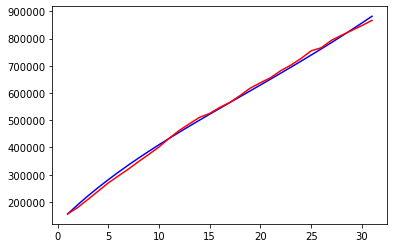

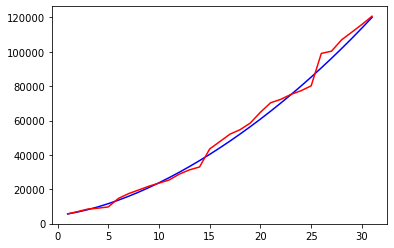

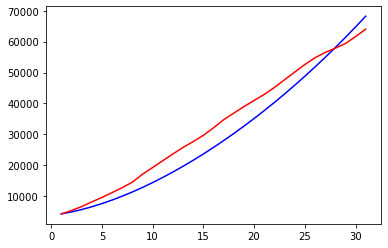

In [15]:
e0=predict.iloc[30,1]
print(e0)
i=0
predict.to_csv('third_predict'+str(i)+'.csv',index=False)
predict=month_yichuan(e0,1)
i=1
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

647755390272212.5
79133695390256.56
79133695390256.56
60024091614655.7
59700493250701.09
56121660980371.72
56121660980371.72
52501323818538.22
48074787659339.25
48074787659339.25
45358058267242.05
44487149963022.13
44487149963022.13
43911015523890.625
43911015523890.625
43911015523890.625
43770426834041.29
43117624600370.375
43117624600370.375
43117624600370.375
43117624600370.375
43117624600370.375
43117624600370.375
43117624600370.375
43117624600370.375
43117624600370.375
43030699792498.09
43030699792498.09
43030699792498.09
43030699792498.09
43030699792498.09
43030699792498.09
42554209148535.84
42401701842602.24
42401701842602.24
42401701842602.24
42401701842602.24
42401701842602.24
42401701842602.24
42401701842602.24
42401701842602.24
30636177759207.64
30636177759207.64
25132980213027.227
25132980213027.227
8441117123878.427
6595957025860.479
1379030815644.2368
594879381420.3892
181378979783.67322
180360227325.12833
91582529479.06522
88033861579.68422
68680156344.8201
48440865848.5

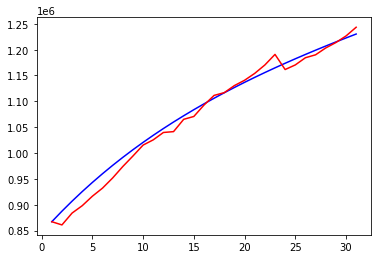

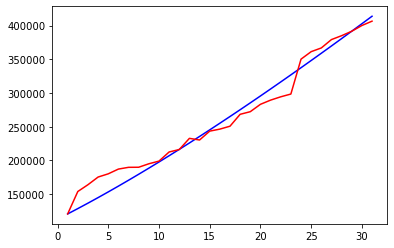

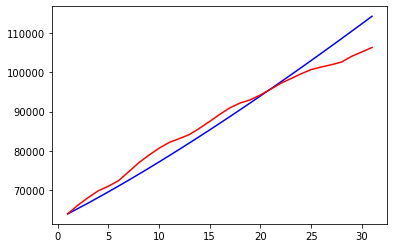

In [16]:
i=2
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

6140825597901279.0
442607909939993.44
146274950569030.4
105812542441588.11
103200336459781.28
100303129613427.31
86581804915603.17
86581804915603.17
86581804915603.17
86581804915603.17
86581804915603.17
85505877389803.67
85505877389803.67
85505877389803.67
85505877389803.67
85505877389803.67
85505877389803.67
85505877389803.67
85505877389803.67
82765229768560.44
82354478635668.58
82354478635668.58
82229029636868.31
82059955902822.2
81942207754146.72
81850195629381.94
81659035401005.34
81659035401005.34
79392626338139.98
79392626338139.98
77234470689012.03
77234470689012.03
77234470689012.03
77234470689012.03
77234470689012.03
77234470689012.03
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
71683513313948.55
716835

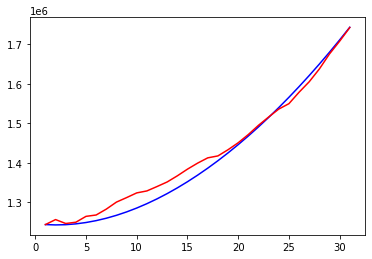

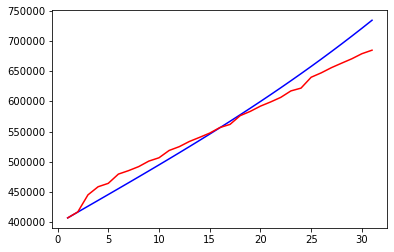

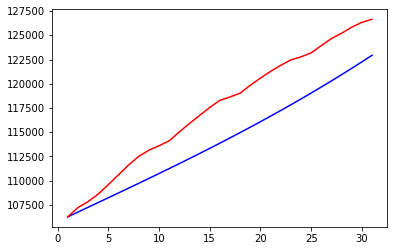

In [17]:
i=3
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

3.782167224508997e+16
519047895193269.8
355325918082186.7
324123441386905.1
323033178919866.44
265180235921813.25
265180235921813.25
252484554930903.47
238243949068324.2
237977105690375.62
215785045202507.1
215785045202507.1
205639422784573.66
204994204860615.5
204772400070831.5
203689753765668.66
190718378523725.38
190041079353266.06
190041079353266.06
190041079353266.06
190041079353266.06
173601466920744.06
173601466920744.06
173601466920744.06
119520102387259.61
119520102387259.61
119520102387259.61
119520102387259.61
119520102387259.61
119520102387259.61
119520102387259.61
117831175754233.48
108835080808435.92
103294786132279.98
100140657645954.62
72440883626672.9
72440883626672.9
59346783160271.6
36182723979360.734
18804748182787.117
7014693675888.196
4965127157596.02
4543332538679.47
3875695009252.8867
3875695009252.8867
2058797867100.638
2058797867100.638
1062846556383.2605
344566102444.7807
292304824161.19055
184405368582.6355
130372492792.08122
113378872947.66855
106795111453.

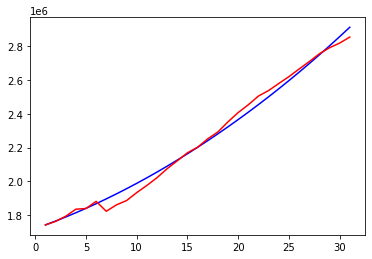

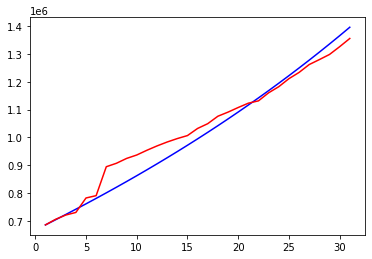

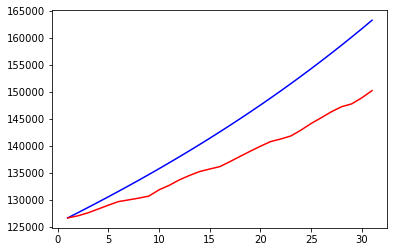

In [18]:
i=4
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

2558397559521667.0
866240901975757.8
747502851749362.2
535809259774507.1
535809259774507.1
528846325035162.9
528793562072512.56
479323729012320.7
479323729012320.7
473813721666718.7
419152621289702.3
416638758535208.25
416638758535208.25
416638758535208.25
416638758535208.25
416638758535208.25
416638758535208.25
416638758535208.25
416638758535208.25
416638758535208.25
416638758535208.25
416638758535208.25
416638758535208.25
416102101382419.56
416102101382419.56
416102101382419.56
416102101382419.56
414378157925163.4
410259495983915.7
410259495983915.7
410259495983915.7
410259495983915.7
410259495983915.7
410259495983915.7
410259495983915.7
404021713681963.44
404021713681963.44
404021713681963.44
404021713681963.44
404021713681963.44
404021713681963.44
390991766516723.4
390991766516723.4
390991766516723.4
390991766516723.4
361646110325622.9
361646110325622.9
361646110325622.9
361646110325622.9
361646110325622.9
361646110325622.9
361646110325622.9
361646110325622.9
361646110325622.9
3614

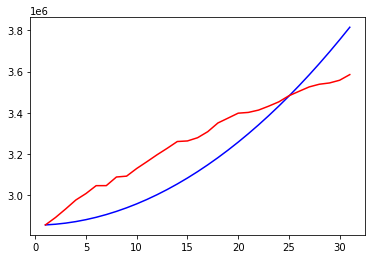

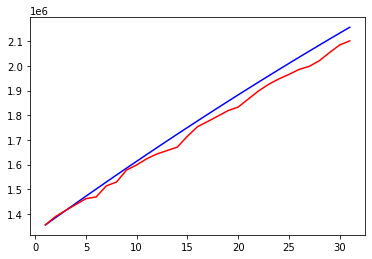

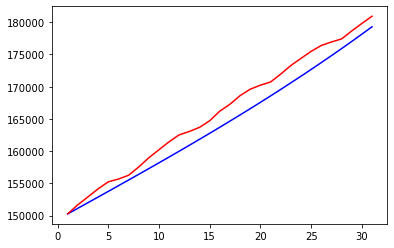

In [19]:
i=5
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

1.699061804822478e+17
1.699061804822478e+17
7.804853411020838e+16
1.0056889543980254e+16
2832778114781622.0
1258332568522943.8
931153113827608.0
802985289687627.0
611754789660226.6
611754789660226.6
611754789660226.6
584500442348316.9
568453968630091.5
568453968630091.5
568453968630091.5
499178468176077.5
363426074742506.7
363426074742506.7
363426074742506.7
267239104059944.56
92823766924663.55
12649758090133.62
5149633052300.904
1406200742607.9575
1151096769338.0852
563343466597.6113
549617903227.79395
549617903227.79395
549617903227.79395
266246580818.7115
266246580818.7115
266246580818.7115
266246580818.7115
266246580818.7115
265284318102.27252
247607010811.25833
247607010811.25833
244855279360.47635
241218331812.84534
238918108244.57993
234055101582.18176
224663999219.69537
224663999219.69537
224663999219.69537
224663999219.69537
224663999219.69537
224663999219.69537
224663999219.69537
224663999219.69537
224663999219.69537
224663999219.69537
224194188251.65344
224194188251.65344
22

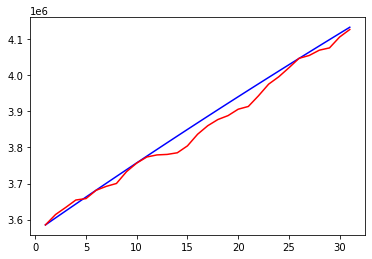

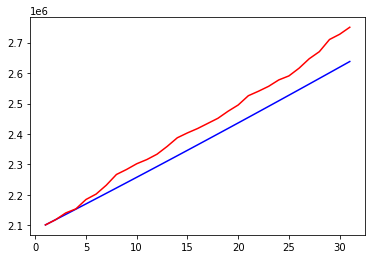

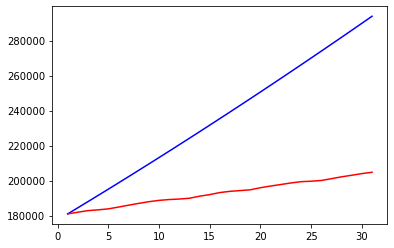

In [20]:
i=6
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

1.3677372425407656e+17
1.4011184121666054e+16
2609850530837841.0
1432398377960764.5
900084307812229.9
893946984787714.4
888246036960668.9
847981231421556.1
841003556154056.9
841003556154056.9
803037829672795.0
801765665885712.8
801153776478612.5
794664628572120.5
794664628572120.5
793645510319255.6
793645510319255.6
793645510319255.6
406473273668089.7
403948451868444.25
397603265915538.5
254805221958088.1
206283250175377.06
153560315980259.28
153559692043214.2
68994872018427.79
56797199522397.2
32156187497857.887
899672531780.4811
499366649848.012
201787027093.02844
134278292240.02057
97654875746.84836
70339360973.324
32449551849.89161
31677459631.821087
31677459631.821087
29711239770.23288
29711239770.23288
25798061706.919846
25798061706.919846
25798061706.919846
8763837099.88242
8763837099.88242
8763837099.88242
8763837099.88242
8763837099.88242
8763837099.88242
8763837099.88242
8763837099.88242
8763837099.88242
8763837099.88242
8763837099.88242
8763837099.88242
8763837099.88242
8763

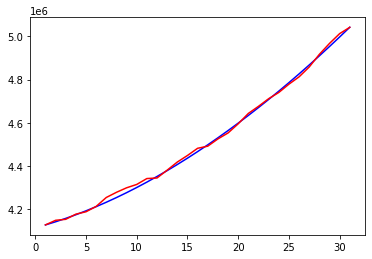

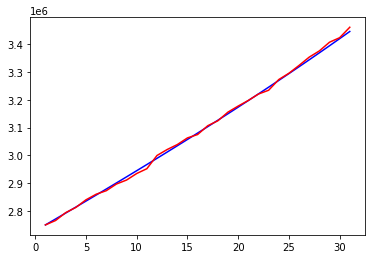

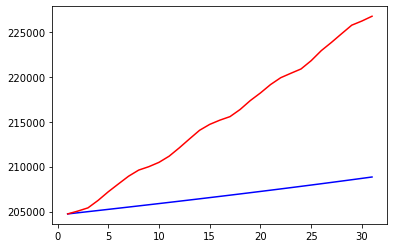

In [21]:
i=7
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

4.646659911596175e+17
1.6418810695396554e+17
1.1020326345654442e+17
3.279947996526577e+16
4843257084953503.0
3128165774767443.0
2758628858434820.0
1957364571119886.2
1720109764626833.5
1720109764626833.5
1441472485112678.5
858198162419130.5
858198162419130.5
858198162419130.5
752959069643604.0
750499504189881.9
750499504189881.9
341261259915869.8
261427889062185.4
123532331728244.27
64141505778315.53
53291786443652.75
13237193487200.26
7371086087944.547
2514380631124.709
979130535991.1345
884500546519.1028
810691985517.294
656364556554.8752
651039967193.7124
628417625351.7797
628417625351.7797
627831730245.1348
604766453820.4304
591977667327.7249
581469511039.9376
580273600698.7793
580273600698.7793
580273600698.7793
580273600698.7793
580273600698.7793
580273600698.7793
580273600698.7793
580273600698.7793
580273600698.7793
575837512624.7949
575837512624.7949
575837512624.7949
573082969318.8466
573082969318.8466
573082969318.8466
570460155406.4609
570460155406.4609
570460155406.4609
570

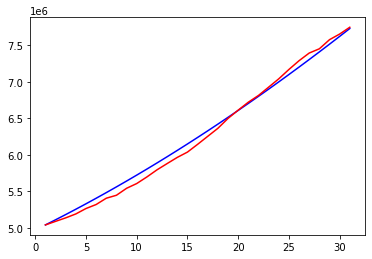

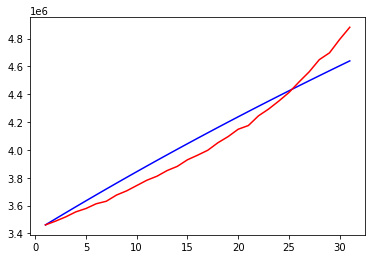

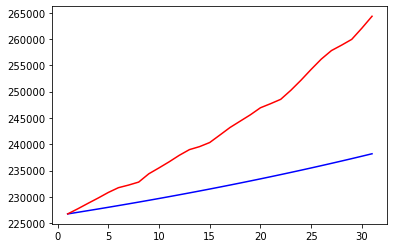

In [22]:
i=8
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

3.380156123721679e+17
2.8268325544364662e+17
3.734830613924541e+16
8182722044462824.0
1755458939578025.5
1371347231345682.5
1371347231345682.5
1371347231345682.5
1371347231345682.5
1371347231345682.5
1371347231345682.5
1371347231345682.5
266629848612882.3
138665550053408.56
72697790725615.2
71120453836884.27
70781771704007.47
69502537132859.06
69022327108955.92
69022327108955.92
68988159373283.45
68935514413796.2
68935514413796.2
68454456396559.64
68454456396559.64
68454456396559.64
68454456396559.64
68454456396559.64
68454456396559.64
68454456396559.64
68454456396559.64
68292962556487.15
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314217601.03
68258314

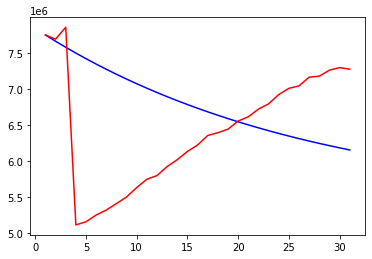

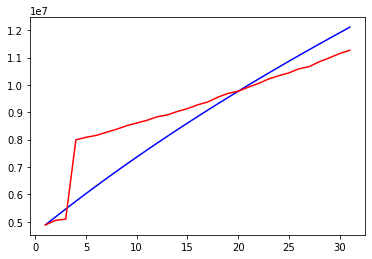

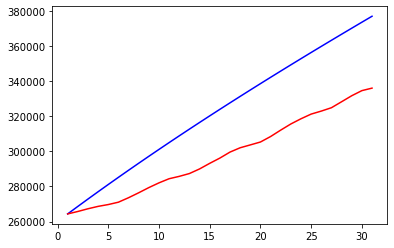

In [23]:
i=9
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

1.5130238150464998e+16
9755521323866732.0
5405988281465103.0
3743001124107019.0
2690796681351783.5
2059161814908688.2
1606487148421600.2
859418548886499.6
859418548886499.6
815890157963358.8
755173506595340.4
532598846263665.6
442744021304047.6
281538379647805.2
273783224027674.38
64537746986249.56
57111607720024.11
12876796585092.209
3004624443864.687
1487671146391.583
791317961407.9344
701336148897.2545
471993810793.0772
427570862736.27936
427570862736.27936
427028792194.9534
424196442350.3342
423812925752.5079
416004196757.0595
415226115907.80304
415226115907.80304
410250074393.12427
410250074393.12427
410250074393.12427
410250074393.12427
410250074393.12427
407833896067.07184
407833896067.07184
407833896067.07184
407833896067.07184
407833896067.07184
407663918236.29407
407663918236.29407
406568704523.5875
405878828433.5934
405878828433.5934
405878828433.5934
405878828433.5934
405878828433.5934
405878828433.5934
405878828433.5934
405878828433.5934
405878828433.5934
405878828433.5934

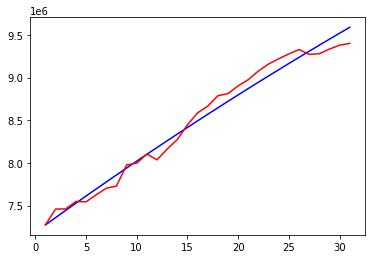

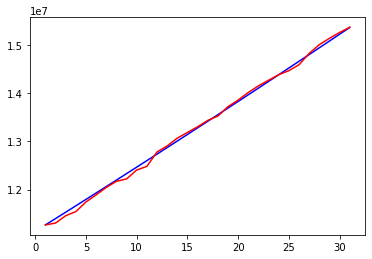

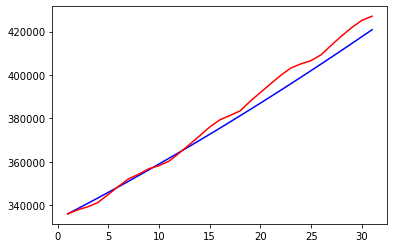

In [24]:
i=10
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

1.4683002366096755e+17
1.203806160830644e+17
4.331076481269645e+16
8491969386099921.0
7968827580074174.0
4526051839017751.0
4510160959343512.0
4295609770971192.5
3974243427490315.0
3252459329958133.0
3252459329958133.0
3252459329958133.0
3252459329958133.0
3252459329958133.0
3252459329958133.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3199451761788688.0
3124795483831504.5
3124795483831504.5
3124795483831504.5
3124795483831504.5
3124795483831504.5
3124795483831504.5
3124795483831504.5
3124795483831504.5
3124795483831504.5
3124795483831504.5
31

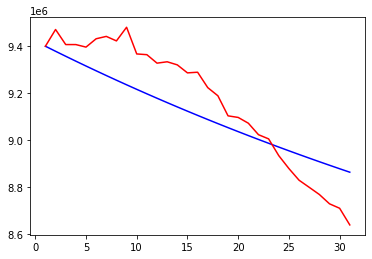

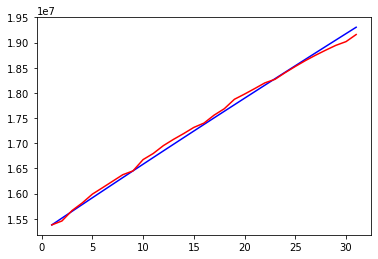

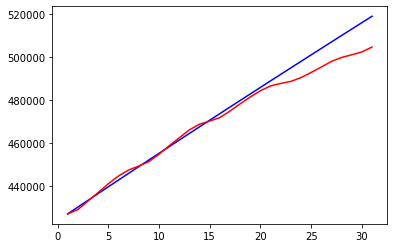

In [25]:
i=11
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

8.055063547153277e+16
6459145273530026.0
4192802344354213.0
3600980135623917.5
2676521570106979.5
2676521570106979.5
1991627894188655.5
1991627894188655.5
1991627894188655.5
1991627894188655.5
1991627894188655.5
1991627894188655.5
1991627894188655.5
1722087547657713.5
1722087547657713.5
1722087547657713.5
1722087547657713.5
1722087547657713.5
1722087547657713.5
1477226846681772.5
1477226846681772.5
1471040652583262.5
1471040652583262.5
1471040652583262.5
1433483782937158.2
1359737223874558.8
986168948194154.2
363211370990253.94
164983539903438.2
51713115893107.33
31227904941153.48
26456721984952.89
14867969621839.408
14156024514366.5
14156024514366.5
9024409370119.408
8853898130075.543
8851308865189.889
8851110563647.951
8425869041782.109
8425869041782.109
8230436291468.452
8230436291468.452
8230436291468.452
8230436291468.452
8230436291468.452
8230436291468.452
8230436291468.452
8230436291468.452
8230436291468.452
8230436291468.452
8230436291468.452
8230436291468.452
8230436291468.452

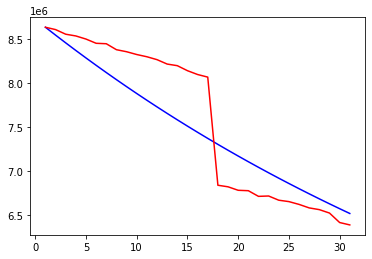

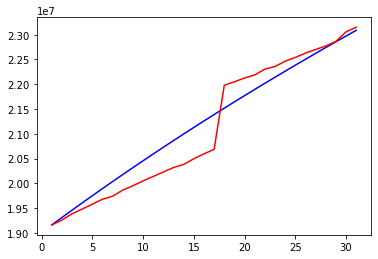

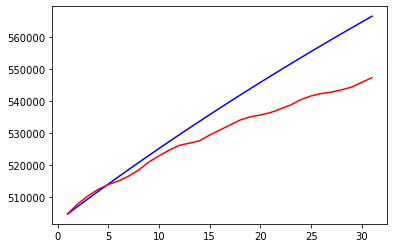

In [26]:
i=12
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

5.294677771661206e+16
3.1273782440938496e+16
1.1022782683886498e+16
1925339986627721.8
1835665143517263.5
1577574288978935.8
1279987157117128.5
416338709079369.6
410491605201867.25
91184902117153.6
53869725519226.04
7942484872592.012
5035210151028.1875
3337903031801.8833
2405642877192.3154
1653763783373.5916
1653763783373.5916
627176020130.7019
539891080975.7343
358201675742.9915
350814669721.0113
94885263604.92241
94885263604.92241
39888599043.287254
39888599043.287254
24742210149.53262
24701491758.517437
23563231955.698784
18193145514.919266
18192267387.959084
18192267387.959084
18189224058.427753
18189224058.427753
18189224058.427753
18144663054.573257
18144663054.573257
18144663054.573257
18138783622.94926
18138783622.94926
18090298268.60515
18090298268.60515
18090298268.60515
17728127834.282677
17652537935.7075
17652537935.7075
17652537935.7075
17652537935.7075
17652537935.7075
17652537935.7075
17652537935.7075
17652537935.7075
17652537935.7075
17652537935.7075
17652537935.7075
17

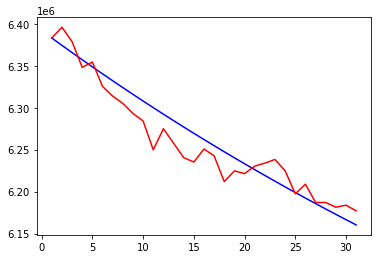

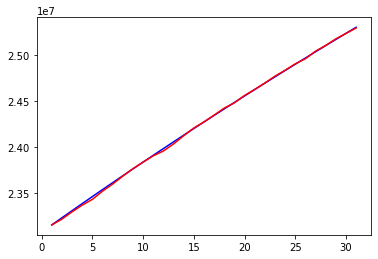

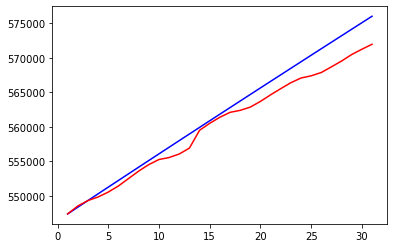

In [27]:
i=13
e0=predict.iloc[30,1]
predict=month_yichuan(e0,i)
print('------------------')
print(e0)
predict.to_csv('third_predict'+str(i)+'.csv',index=False)

In [28]:
e0=predict.iloc[30,1]
print(e0)
def final_count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha):
    s=s;e=e;i=i;r=r;d=d;beta=beta;r1=r1;r2d=r2d;r2r=r2r;n=n
    S=[s];E=[e];I=[i];R=[r];D=[d]
    for m in range(6000):
        ds=delta_s(beta,s,i,n,alpha)
        de=delta_e(beta,s,i,n,r1,e)
        di=delta_i(r1,e,r2d,r2r,i)
        dr=delta_r(r2r,i,alpha,s)
        dd=delta_d(r2d,i)
        s=s+ds
        e=e+de
        i=i+di
        r=r+dr
        d=d+dd
        S.append(s)
        E.append(e)
        I.append(i)
        R.append(r)
        D.append(d)
    result=pd.DataFrame({
        'S':S,
        'E':E,
        '累计确诊':I,
        '治愈人数':R,
        '死亡人数':D
        })
    return result
def final_yuce(beta,r1,e0,r2d,r2r,month,alpha):
    n=326766748#总人口数
    e=e0#初始的感染但是并没有发病的数量
    i=y1[30*month]#初始的感染数量
    r=y2[30*month]#初始的治愈数量
    d=y3[30*month]#初始的死亡数量
    s=n-e-i-r-d#未被感染数
    beta=beta
    r1=r1
    r2d=r2d
    r2r=r2r
    predict=final_count(s,e,i,r,d,beta,r1,r2d,r2r,n,alpha)
    print(n*0.00001)
    return predict

263548727.48765245


In [45]:
canshu1=[[0.495513916015625, 0.0001220703125, 0.000152587890625, 0.006072998046875, 0.00091552734375]]
canshu2=[[0.20306396484375, 0.000213623046875, 0.000274658203125, 0.01629638671875, 0.00018310546875]]
canshu3=[[0.09930419921875, 0.0003662109375, 0.000335693359375, 0.0115966796875, 0.00048828125]]
final_result=final_yuce(0.5, 0.0005220703125,263548727,0.000152587890625, 0.016072998046875, 14,0.0091552734375)

3267.66748


In [46]:
final_result.to_csv('final_Improve.csv',index=False)